# What is Semantic Segmentation?
Semantic segmentation refers to the process of linking each pixel in an image to a class label. These labels could include a person, car, flower, piece of furniture, etc., just to mention a few.
We can think of semantic segmentation as image classification at a pixel level. For example, in an image that has many cars, segmentation will label all the objects as car objects. However, a separate class of models known as instance segmentation is able to label the separate instances where an object appears in an image. This kind of segmentation can be very useful in applications that are used to count the number of objects, such as counting the amount of foot traffic in a mall.

# Import Libraries

In [1]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.4 MB/s eta 0:00:00


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from zipfile import ZipFile

from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Mount Google Drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/POZNAN UNIVERSITY/project_3_CV'
#folder_path = '/content/drive/MyDrive/project_3_CV'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data import

Run the following chunk just the first time.

In [66]:
with ZipFile(folder_path+"/Data/dataset.zip", 'r') as zipObj:

    zipObj.extractall(
        path=folder_path+"/Data")

# Preprocessing

In [19]:
IMAGE_PATH = folder_path+'/Data/semantic_drone_dataset/original_images/'
MASK_PATH = folder_path+'/Data/semantic_drone_dataset/label_images_semantic/'

In [67]:
n_classes = 23

def create_df():
    name = []
    count = 0

    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
            count += 1
            if count == 400:
              break

    print(count)
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

400
Total Images:  400


In [68]:
#split data
# they store the idx of the images (the idx of the mask is the same) and use this index to call the mask
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


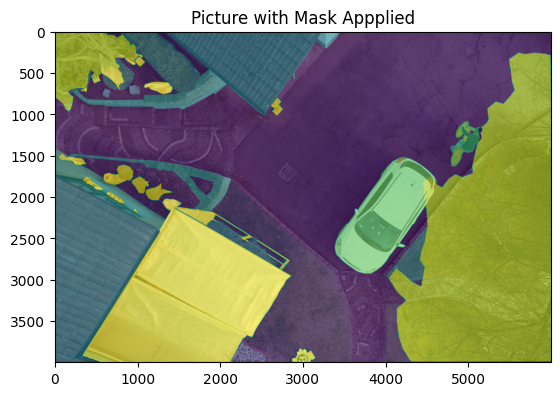

In [22]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [23]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [24]:
### We use the albumentation framework to perform data augmentation
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([

    A.RandomCrop(height=2048, width = 2048, p = 0.75),
    A.Flip(p=0.5),
    A.GaussNoise(p=0.60),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.3, p=0.75),
    A.OneOf([
            A.MedianBlur(blur_limit=3, p=0.50),
            A.Blur(blur_limit=3, p=0.50),
        ], p=0.33),

    A.RandomGridShuffle(grid=(2,2), p=0.2),
    A.Resize(height=1024, width=2016, interpolation=cv2.INTER_NEAREST, p=1)
])

t_val = A.Compose([A.Flip(),
                   A.GridDistortion(p=0.2),
                   A.Resize(height=1024, width=2016, interpolation=cv2.INTER_NEAREST, p=1)])


#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [25]:
# Print the total number of images
num_images = len(train_loader.dataset)
print("Total number of images:", num_images)

Total number of images: 306


In [26]:
# Print the total number of images
num_images = len(val_loader.dataset)
print("Total number of images:", num_images)

Total number of images: 54


# Model

In [27]:
model_custom_unet = smp.Unet(
    'timm-mobilenetv3_small_075',
    encoder_weights='imagenet',
    classes=23,
    activation='softmax',
    encoder_depth=5)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_075-da427f52.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_075-da427f52.pth
100%|██████████| 7.86M/7.86M [00:00<00:00, 74.4MB/s]


In [28]:
model_custom_unet.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 23, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Softmax(dim=None)
  )
)

In [29]:
model_custom_manet = smp.MAnet(
    'timm-mobilenetv3_small_075',
    encoder_weights='imagenet',
    classes=23,
    activation='softmax',
    encoder_depth=5)

In [30]:
model_custom_manet.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 23, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Softmax(dim=None)
  )
)

In [31]:
model_custom_FPN = smp.FPN(
    'timm-mobilenetv3_small_075',
    encoder_weights='imagenet',
    classes=23,
    activation='softmax',
    encoder_depth=5)

In [32]:
model_custom_FPN.segmentation_head

SegmentationHead(
  (0): Conv2d(128, 23, kernel_size=(1, 1), stride=(1, 1))
  (1): UpsamplingBilinear2d(scale_factor=4.0, mode='bilinear')
  (2): Activation(
    (activation): Softmax(dim=None)
  )
)

# Training

In [33]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [34]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [35]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history


def k_fold_cross_validation(n_fold, epochs, model, criterion, optimizer, dataset=X_trainval, patch=False):

    kf = KFold(n_splits=n_fold, shuffle=True, random_state=1)

    histories = []

    for fold, (train_index, val_index) in enumerate(kf.split(X_trainval)):
        print(f"Fold {fold + 1}/{n_fold}")

        X_train = torch.utils.data.Subset(X_trainval, train_index)
        X_val = torch.utils.data.Subset(X_trainval, val_index)

        train_dataset = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
        val_dataset = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        print("Longueur train loader", len(train_loader))

        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

        # Train the model for the current fold
        history = fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch)

        histories.append(history)

    return histories

In [36]:
max_lr = 1e-2
epoch = 8
weight_decay = 1e-3

criterion = nn.CrossEntropyLoss()

# Define three different Adam optimizers
optimizer_custom_unet = torch.optim.AdamW(model_custom_unet.parameters(), lr=max_lr, weight_decay=weight_decay)
optimizer_custom_manet = torch.optim.AdamW(model_custom_manet.parameters(), lr=max_lr, weight_decay=weight_decay)
optimizer_custom_FPN = torch.optim.AdamW(model_custom_FPN.parameters(), lr=max_lr, weight_decay=weight_decay)


# The learning rate scheduler (scheduler) is responsible for controlling how the learning rate changes
# over the course of training. It's a strategy to improve training performance and convergence.
sched_custom_unet = torch.optim.lr_scheduler.OneCycleLR(optimizer_custom_unet, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
sched_custom_manet = torch.optim.lr_scheduler.OneCycleLR(optimizer_custom_manet, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
sched_custom_FPN = torch.optim.lr_scheduler.OneCycleLR(optimizer_custom_FPN, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

In [37]:
#history_custom_FPN = fit(epoch, model_custom_FPN, train_loader, val_loader, criterion, optimizer_custom_FPN, sched_custom_FPN)
#torch.save(model_custom_FPN, 'FPN-custom-Mobilenet.pt')

In [38]:
history_custom_FPN_file = 'history_custom_FPN.json'

In [39]:
''' with open(history_custom_FPN_file, 'w') as f:
    json.dump(history_custom_FPN, f) '''

" with open(history_custom_FPN_file, 'w') as f:\n    json.dump(history_custom_FPN, f) "

In [40]:
#history_custom_manet = fit(epoch, model_custom_manet, train_loader, val_loader, criterion, optimizer_custom_manet, sched_custom_manet)
#torch.save(model_custom_manet, 'MAnet-custom-Mobilenet.pt')

In [41]:
history_custom_manet_file = 'history_custom_manet.json'

In [42]:
''' with open(history_custom_manet_file, 'w') as f:
    json.dump(history_custom_manet, f) '''

" with open(history_custom_manet_file, 'w') as f:\n    json.dump(history_custom_manet, f) "

In [43]:
#history_custom_unet = fit(epoch, model_custom_unet, train_loader, val_loader, criterion, optimizer_custom_unet, sched_custom_unet)
#torch.save(model_custom_unet, 'Unet-custom-Mobilenet.pt')

In [44]:
history_custom_unet_file = 'history_custom_unet.json'

In [45]:
''' with open(history_custom_unet_file, 'w') as f:
    json.dump(history_custom_unet, f) '''

" with open(history_custom_unet_file, 'w') as f:\n    json.dump(history_custom_unet, f) "

# Already trained models loading

In [46]:
with open(history_custom_manet_file, 'r') as f:
    history_custom_manet = json.load(f)

with open(history_custom_unet_file, 'r') as f:
    history_custom_unet = json.load(f)

with open(history_custom_FPN_file, 'r') as f:
    history_custom_FPN = json.load(f)


FileNotFoundError: [Errno 2] No such file or directory: 'history_custom_manet.json'

In [ ]:
best_model = None
best_val_acc = 0.0

if history_custom_manet['val_acc'][-1] > best_val_acc:
    best_val_acc = history_custom_manet['val_acc'][-1]
    best_model = model_custom_manet

if history_custom_unet['val_acc'][-1] > best_val_acc:
    best_val_acc = history_custom_unet['val_acc'][-1]
    best_model = model_custom_unet

if history_custom_FPN['val_acc'][-1] > best_val_acc:
    best_val_acc = history_custom_FPN['val_acc'][-1]
    best_model = model_custom_FPN

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("Corresponding Best Model:")
print(best_model)


In [51]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, num_classes=23):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.num_classes = num_classes

    def convert_to_binary_mask(self, target):
        # Convert class indices to binary masks
        binary_masks = [torch.eq(target, i) for i in range(self.num_classes)]
        binary_masks = torch.stack(binary_masks, dim=1).float()
        return binary_masks

    def forward(self, predicted, target):
        # Convert class indices to binary masks
        target_masks = self.convert_to_binary_mask(target)

        # Flatten the predictions and target masks
        predicted_flat = predicted.view(-1)
        target_flat = target_masks.view(-1)

        # Intersection and Union
        intersection = torch.sum(predicted_flat * target_flat)
        union = torch.sum(predicted_flat) + torch.sum(target_flat)

        # Calculate Dice coefficient
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Calculate Dice loss
        loss = 1.0 - dice

        return loss

class DiceCrossEntropyLoss(nn.Module):
    def __init__(self, dice_smooth=1.0, num_classes=23):
        super(DiceCrossEntropyLoss, self).__init__()
        self.dice_smooth = dice_smooth
        self.num_classes = num_classes

    def convert_to_binary_mask(self, target):
        # Convert class indices to binary masks
        binary_masks = [torch.eq(target, i) for i in range(self.num_classes)]
        binary_masks = torch.stack(binary_masks, dim=1).float()
        return binary_masks

    def forward(self, predicted, target):
        # Convert class indices to binary masks
        target_masks = self.convert_to_binary_mask(target)

        # Flatten the predictions and target masks
        predicted_flat = predicted.view(-1)
        target_flat = target_masks.view(-1)

        # Intersection and Union for Dice Loss
        intersection = torch.sum(predicted_flat * target_flat)
        union = torch.sum(predicted_flat) + torch.sum(target_flat)
        dice = (2.0 * intersection + self.dice_smooth) / (union + self.dice_smooth)
        dice_loss = 1.0 - dice

        # Cross-Entropy Loss
        ce_loss = F.cross_entropy(predicted, target)

        # Combine Dice Loss and Cross-Entropy Loss
        combined_loss = dice_loss + ce_loss

        return combined_loss



In [49]:
best_model = smp.FPN(
    'timm-mobilenetv3_small_075',
    encoder_weights='imagenet',
    classes=23,
    activation='softmax',
    encoder_depth=5)

In [52]:
max_lr = 1e-2
epoch = 8
weight_decay = 1e-3

# Define three different loss functions
criterion1 = DiceCrossEntropyLoss()
criterion2 = DiceLoss()

# Define three different optimizers
optimizer1 = torch.optim.SGD(best_model.parameters(), lr=max_lr)
optimizer2 = torch.optim.RMSprop(best_model.parameters(), lr=max_lr)


# The learning rate scheduler (scheduler) is responsible for controlling how the learning rate changes
# over the course of training. It's a strategy to improve training performance and convergence.
sched1 = torch.optim.lr_scheduler.OneCycleLR(optimizer1, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
sched2 = torch.optim.lr_scheduler.OneCycleLR(optimizer2, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

In [54]:
torch.save(best_model, 'FPN-custom-Mobilenet.pt')

In [53]:
history1 = fit(epoch, best_model, train_loader, val_loader, criterion1, optimizer1, sched1)
torch.save(best_model, 'FPN-custom-Mobilenet.pt')

  0%|          | 0/102 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 3.550 
Epoch:1/8.. Train Loss: 3.516.. Val Loss: 3.550.. Train mIoU:0.030.. Val mIoU: 0.018.. Train Acc:0.358.. Val Acc:0.329.. Time: 9.09m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:2/8.. Train Loss: 3.380.. Val Loss: 3.555.. Train mIoU:0.030.. Val mIoU: 0.018.. Train Acc:0.414.. Val Acc:0.326.. Time: 9.03m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 3.555 >> 3.553 
Epoch:3/8.. Train Loss: 3.382.. Val Loss: 3.553.. Train mIoU:0.031.. Val mIoU: 0.017.. Train Acc:0.413.. Val Acc:0.327.. Time: 8.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 3.553 >> 3.550 
Epoch:4/8.. Train Loss: 3.381.. Val Loss: 3.550.. Train mIoU:0.031.. Val mIoU: 0.018.. Train Acc:0.413.. Val Acc:0.329.. Time: 9.05m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 3.550 >> 3.548 
saving model...
Epoch:5/8.. Train Loss: 3.377.. Val Loss: 3.548.. Train mIoU:0.032.. Val mIoU: 0.019.. Train Acc:0.415.. Val Acc:0.330.. Time: 9.05m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/8.. Train Loss: 3.375.. Val Loss: 3.549.. Train mIoU:0.031.. Val mIoU: 0.018.. Train Acc:0.416.. Val Acc:0.329.. Time: 8.61m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/8.. Train Loss: 3.357.. Val Loss: 3.553.. Train mIoU:0.033.. Val mIoU: 0.017.. Train Acc:0.425.. Val Acc:0.327.. Time: 8.54m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:8/8.. Train Loss: 3.379.. Val Loss: 3.554.. Train mIoU:0.030.. Val mIoU: 0.017.. Train Acc:0.414.. Val Acc:0.327.. Time: 9.00m
Total time: 71.09 m


NameError: name 'model_FPN_definitive' is not defined

In [ ]:
history_1_file = 'history_1_file.json'

In [ ]:
''' with open(history_1_file, 'w') as f:
    json.dump(history1, f) '''

In [ ]:
#history2 = fit(epoch, best_model, train_loader, val_loader, criterion2, optimizer2, sched2)

In [ ]:
history_2_file = 'history_2_file.json'

In [ ]:
''' with open(history_2_file, 'w') as f:
    json.dump(history2, f) '''

In [ ]:
with open(history_1_file, 'r') as f:
    history_1 = json.load(f)

with open(history_2_file, 'r') as f:
    history_2 = json.load(f)

# Cross Validation

In [ ]:
# Manet using k-fold cross-validation
num_fold = 5
epoch = 2
history_kfold_manet = k_fold_cross_validation(num_fold, epoch, best_model, criterion, optimizer_custom_manet)
torch.save(history_kfold_manet, "KFold-Manet.pt")

In [ ]:
history_kfold_file = 'history_kfold_file.json'
with open(history_kfold_file, 'r') as f:
    history_kfold = json.load(f)

# Plots

Accuracy values of the three models.

In [ ]:
# Extract the training and validation accuracies from the histories
train_acc_manet = history_custom_manet['train_acc']
val_acc_manet = history_custom_manet['val_acc']

train_acc_unet = history_custom_unet['train_acc']
val_acc_unet = history_custom_unet['val_acc']

train_acc_FPN = history_custom_FPN['train_acc']
val_acc_FPN = history_custom_FPN['val_acc']

# Define colors for each model
color_manet = 'blue'
color_unet = 'green'
color_fpn = 'red'

# Plot the training and validation accuracies on a single graph
plt.figure(figsize=(10, 6))

# Training accuracy curves
plt.plot(train_acc_manet, label='Custom MANet (Train)', marker='o', color=color_manet)
plt.plot(train_acc_unet, label='Custom UNet (Train)', marker='o', color=color_unet)
plt.plot(train_acc_FPN, label='Custom FPN (Train)', marker='o', color=color_fpn)

# Validation accuracy curves
plt.plot(val_acc_manet, label='Custom MANet (Val)', linestyle='dashed', marker='o', color=color_manet)
plt.plot(val_acc_unet, label='Custom UNet (Val)', linestyle='dashed', marker='o', color=color_unet)
plt.plot(val_acc_FPN, label='Custom FPN (Val)', linestyle='dashed', marker='o', color=color_fpn)

plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


mIoU values of the three models.

In [ ]:
# Extract the training and validation mIoU values from the histories
train_miou_manet = history_custom_manet['train_miou']
val_miou_manet = history_custom_manet['val_miou']

train_miou_unet = history_custom_unet['train_miou']
val_miou_unet = history_custom_unet['val_miou']

train_miou_FPN = history_custom_FPN['train_miou']
val_miou_FPN = history_custom_FPN['val_miou']

# Define colors for each model
color_manet = 'blue'
color_unet = 'green'
color_fpn = 'red'

# Plot the training and validation mIoU values on a single graph
plt.figure(figsize=(10, 6))

# Training mIoU curves
plt.plot(train_miou_manet, label='Custom MANet (Train)', marker='o', color=color_manet)
plt.plot(train_miou_unet, label='Custom UNet (Train)', marker='o', color=color_unet)
plt.plot(train_miou_FPN, label='Custom FPN (Train)', marker='o', color=color_fpn)

# Validation mIoU curves
plt.plot(val_miou_manet, label='Custom MANet (Val)', linestyle='dashed', marker='o', color=color_manet)
plt.plot(val_miou_unet, label='Custom UNet (Val)', linestyle='dashed', marker='o', color=color_unet)
plt.plot(val_miou_FPN, label='Custom FPN (Val)', linestyle='dashed', marker='o', color=color_fpn)

plt.title('Training and Validation mIoU Comparison')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()
plt.grid(True)
plt.show()


Accuracy values of the best model (FPN) with different loss functions and optimizers.

In [ ]:
# Extract the training and validation accuracies from the histories
train_acc_customLoss = history_1['train_acc']
val_acc_customLoss = history_1['val_acc']

train_acc_diceLoss = history_2['train_acc']
val_acc_diceLoss = history_2['val_acc']

train_acc_customFPN = history_custom_FPN['train_acc']
val_acc_customFPN = history_custom_FPN['val_acc']

# Define colors for each model
color_1 = 'blue'
color_2 = 'red'
color_3 = 'green'  # Add a color for the third model

# Plot the training and validation accuracies on a single graph
plt.figure(figsize=(10, 6))

# Training accuracy curves
plt.plot(train_acc_customLoss, label='DiceCrossEntropyLoss and SGD optimizer (train)', marker='o', color=color_1)
plt.plot(train_acc_diceLoss, label='DiceLoss and RMSprop optimizer (train)', marker='o', color=color_2)
plt.plot(train_acc_customFPN, label='CrossEntropyLoss and AdamW optimizer (train)', marker='o', color=color_3)

# Validation accuracy curves
plt.plot(val_acc_customLoss, label='DiceCrossEntropyLoss and SGD optimizer (Val)', linestyle='dashed', marker='o', color=color_1)
plt.plot(val_acc_diceLoss, label='DiceLoss and RMSprop optimizer (Val)', linestyle='dashed', marker='o', color=color_2)
plt.plot(val_acc_customFPN, label='CrossEntropyLoss and AdamW optimizer (Val)', linestyle='dashed', marker='o', color=color_3)

plt.title('Training and Validation Accuracy Comparison for the best model (FPN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


mIoU values of the best model (FPN) with different loss functions and optimizers.

In [ ]:
# Extract the training and validation mIoU from the histories
train_miou_customLoss = history_1['train_miou']
val_miou_customLoss = history_1['val_miou']

train_miou_diceLoss = history_2['train_miou']
val_miou_diceLoss = history_2['val_miou']

train_miou_customFPN = history_custom_FPN['train_miou']
val_miou_customFPN = history_custom_FPN['val_miou']

# Plot the training and validation mIoU on a single graph
plt.figure(figsize=(10, 6))

# Training mIoU curves
plt.plot(train_miou_customLoss, label='DiceCrossEntropyLoss and SGD optimizer (train)', marker='o', color=color_1)
plt.plot(train_miou_diceLoss, label='DiceLoss and RMSprop optimizer (train)', marker='o', color=color_2)
plt.plot(train_miou_customFPN, label='CrossEntropyLoss and AdamW optimizer (train)', marker='o', color=color_3)

# Validation mIoU curves
plt.plot(val_miou_customLoss, label='DiceCrossEntropyLoss and SGD optimizer (Val)', linestyle='dashed', marker='o', color=color_1)
plt.plot(val_miou_diceLoss, label='DiceLoss and RMSprop optimizer (Val)', linestyle='dashed', marker='o', color=color_2)
plt.plot(val_miou_customFPN, label='CrossEntropyLoss and AdamW optimizer (Val)', linestyle='dashed', marker='o', color=color_3)

plt.title('Training and Validation mIoU Comparison for the best model (FPN)')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()
plt.grid(True)
plt.show()


# Evaluation

In [69]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [85]:
model = torch.load(folder_path+'/trained_models/MAnet-custom-Mobilenet.pt')

In [73]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [74]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [86]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [87]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [88]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [89]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [90]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

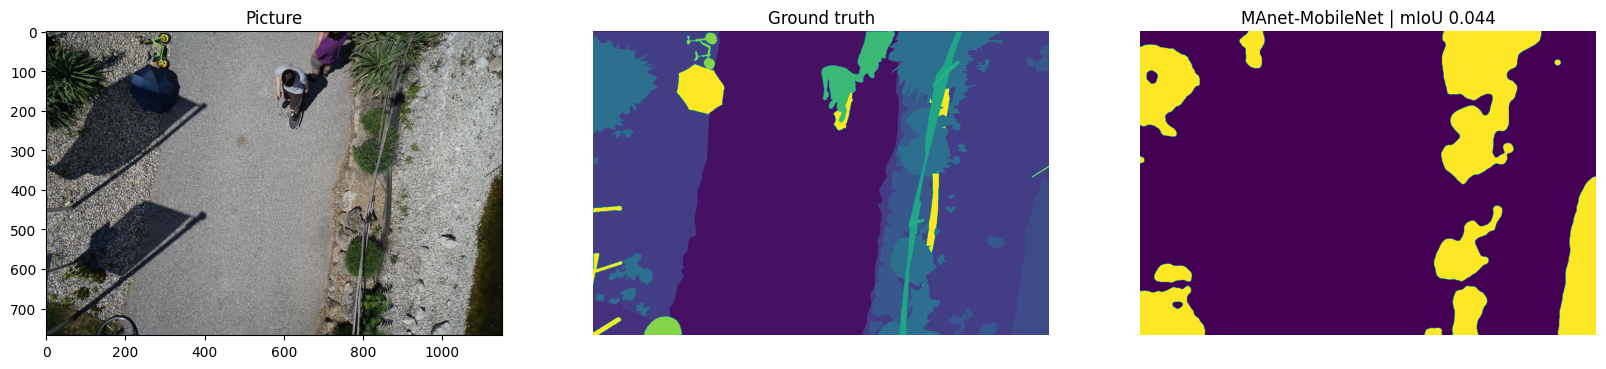

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('MAnet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

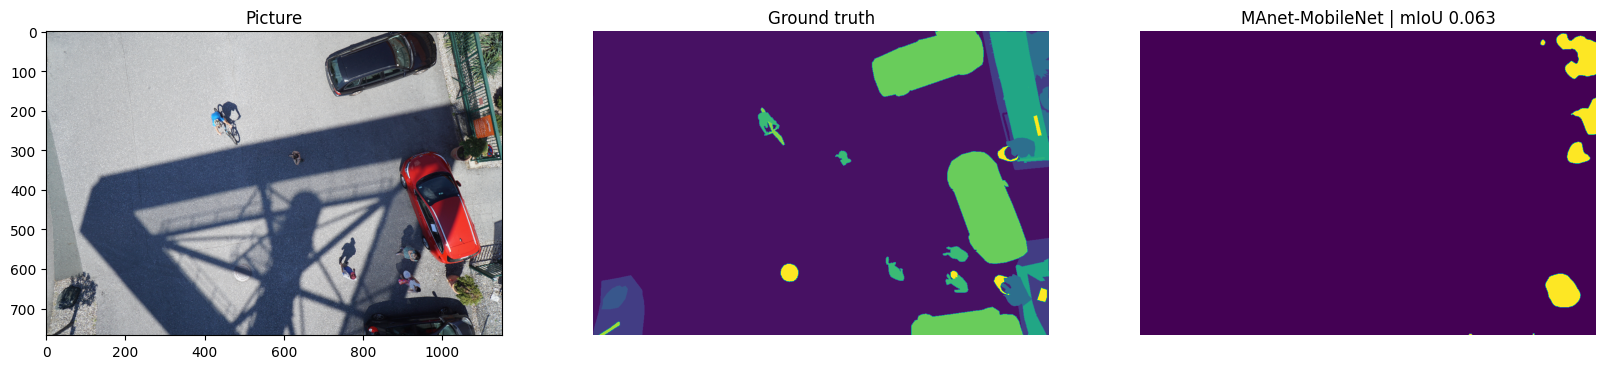

In [97]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('MAnet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

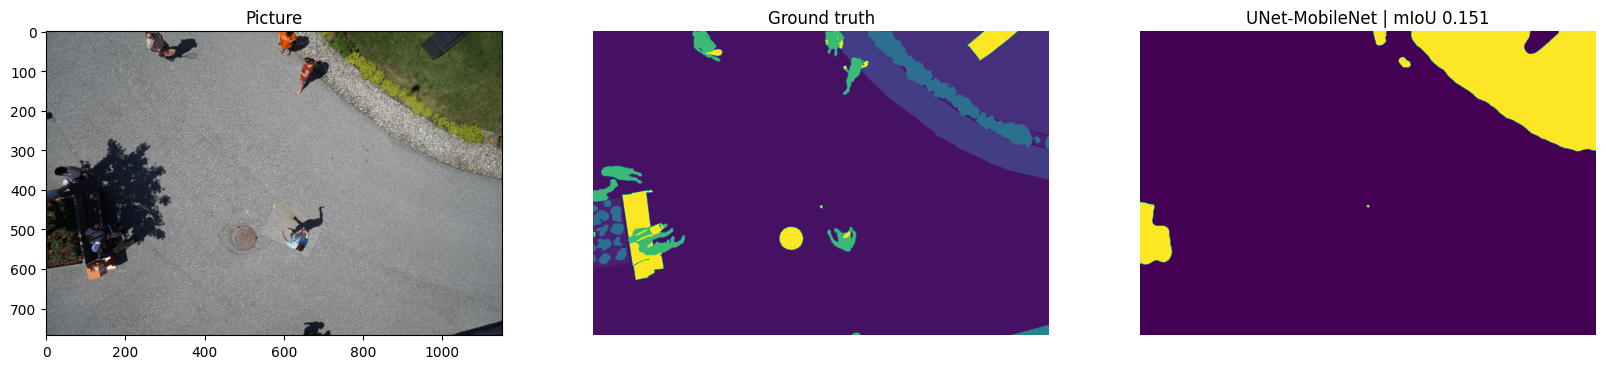

In [93]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [94]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.06742207897530408


In [95]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.5146959940592447
